# Implementing RNNs for sequence modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset
from torch.distributions.categorical import Categorical


from torchtext.datasets import IMDB
from torchtext.vocab import Vocab
import torchtext

from datasets import load_dataset
import re 
from collections import Counter, OrderedDict

/home/mert/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(1)

In [3]:
imdb = load_dataset("imdb")

train_dataset = imdb['train']
test_dataset  = imdb['test']

Reusing dataset imdb (/home/mert/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 1257.54it/s]


In [4]:
train_dataset, valid_datast = random_split(train_dataset, [20000, 5000])

In [5]:
text_pipeline  = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == "pos" else 0.

In [6]:
token_counts = Counter()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

for example in train_dataset:
    tokens = tokenizer(example['text'])  
    token_counts.update(tokens)

from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

def collate_batch(batch):
    texts, labels = zip(*[(example['text'], example['label']) for example in batch])
    # Textleri sayılara çevir
    text_indices = [torch.tensor([vocab[token] for token in tokenizer(text)]) for text in texts]
    lengths = torch.tensor([len(indices) for indices in text_indices])
    padded_texts = torch.nn.utils.rnn.pad_sequence(text_indices, batch_first=True)
    return padded_texts, torch.tensor(labels), lengths

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)

text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

[11, 7, 35, 457]
tensor([[   35,  1739,     7,   449,   721,     6,   301,     4,   787,     9,
             4,    18,    44,     2,  1705,  2460,   186,    25,     7,    24,
           100,  1874,  1739,    25,     7, 34414,  3568,  1103,  7517,   787,
             5,     2,  4991, 12401,    36,     7,   148,   111,   939,     6,
         11598,     2,   172,   135,    62,    25,  3199,  1602,     3,   928,
          1500,     9,     6,  4601,     2,   155,    36,    14,   274,     4,
         42944,     9,  4991,     3,    14, 10296,    34,  3568,     8,    51,
           148,    30,     2,    58,    16,    11,  1893,   125,     6,   420,
          1214,    27, 14542,   940,    11,     7,    29,   951,    18,    17,
         15994,   459,    34,  2480, 15211,  3713,     2,   840,  3200,     9,
          3568,    13,   107,     9,   175,    94,    25,    51, 10297,  1796,
            27,   712,    16,     2,   220,    17,     4,    54,   722,   238,
           395,     2,   787,    32

In [7]:
batch_size = 32  

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_datast, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [8]:
length_batch, text_batch[2].size()

(tensor([165,  86, 218, 145]), torch.Size([218]))

In [9]:
embedding = nn.Embedding(num_embeddings=10, 
                         embedding_dim=3, 
                         padding_idx=0)
 
# a batch of 2 samples of 4 indices each
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))

tensor([[[ 0.7039, -0.8321, -0.4651],
         [-0.3203,  2.2408,  0.5566],
         [-0.4643,  0.3046,  0.7046],
         [-0.7106, -0.2959,  0.8356]],

        [[-0.4643,  0.3046,  0.7046],
         [ 0.0946, -0.3531,  0.9124],
         [-0.3203,  2.2408,  0.5566],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


In [10]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
vocab_size = len(vocab)
embed_dim  = 20 
rnn_hidden_size = 64
fc_hidden_size  = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model = model.to(device)
model   

RNN(
  (embedding): Embedding(69008, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.BCELoss()

In [14]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        text_batch, label_batch, lengths = text_batch.to(device), label_batch.to(device), lengths.to(device) 
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred.float(), label_batch.float())
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [15]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            text_batch, label_batch, lengths = text_batch.to(device), label_batch.to(device), lengths.to(device) 
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred.float(), label_batch.float())
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [16]:
results = []  

num_epoch = 10 
torch.manual_seed(1)
for epoch in range(num_epoch):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
          f' val_accuracy: {acc_valid:.4f}' 
          f' train loss {loss_train:.4f}'
          f' valid loss {loss_valid:.4f}')
    
    results.append({  
        'Epoch': epoch,  
        'Train Accuracy': acc_train,  
        'Validation Accuracy': acc_valid,  
        'Train Loss': loss_train,  
        'Validation Loss': loss_valid  
    })  

Epoch 0 accuracy: 0.6079 val_accuracy: 0.7024 train loss 0.6541 valid loss 0.5829
Epoch 1 accuracy: 0.7304 val_accuracy: 0.7006 train loss 0.5396 valid loss 0.5681
Epoch 2 accuracy: 0.7752 val_accuracy: 0.7932 train loss 0.4749 valid loss 0.4613
Epoch 3 accuracy: 0.7921 val_accuracy: 0.7722 train loss 0.4522 valid loss 0.5550
Epoch 4 accuracy: 0.8214 val_accuracy: 0.8030 train loss 0.4022 valid loss 0.4348
Epoch 5 accuracy: 0.8783 val_accuracy: 0.8356 train loss 0.2952 valid loss 0.3717
Epoch 6 accuracy: 0.9056 val_accuracy: 0.8380 train loss 0.2379 valid loss 0.3808
Epoch 7 accuracy: 0.9281 val_accuracy: 0.8422 train loss 0.1943 valid loss 0.4055
Epoch 8 accuracy: 0.9436 val_accuracy: 0.8704 train loss 0.1553 valid loss 0.3635
Epoch 9 accuracy: 0.9559 val_accuracy: 0.8640 train loss 0.1257 valid loss 0.3787


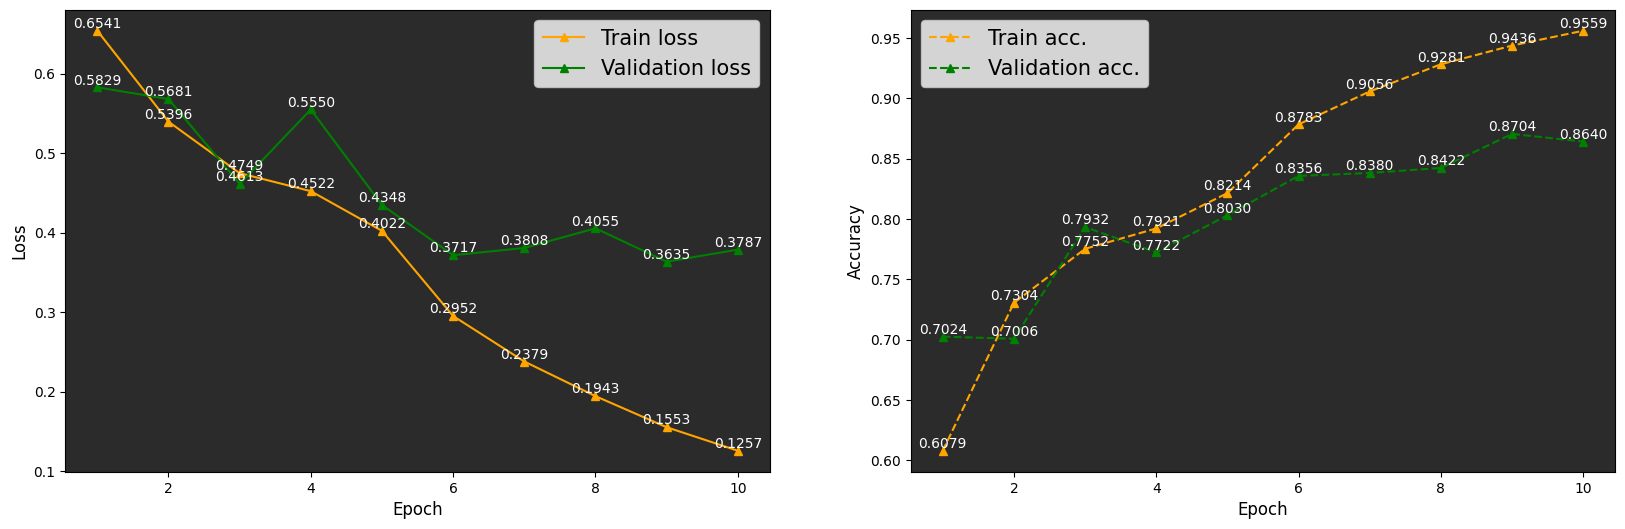

In [17]:
results = pd.DataFrame(results)  

hist_train_loss = results['Train Loss'].to_numpy()  
hist_val_loss   = results['Validation Loss'].to_numpy()  
hist_train_acc  = results['Train Accuracy'].to_numpy()  
hist_val_acc    = results['Validation Accuracy'].to_numpy()

x_arr = np.arange(len(hist_train_loss)) + 1  
fig = plt.figure(figsize=(20, 6))  

ax = fig.add_subplot(1, 2, 1)  
ax.plot(x_arr, hist_train_loss, '-^', label='Train loss', color='orange')   
ax.plot(x_arr, hist_val_loss, '-^', label='Validation loss', color='green')   
ax.legend(fontsize=15)  
ax.set_ylabel('Loss', size=12)  
ax.set_xlabel('Epoch', size=12)  
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist_train_loss):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

for i, value in enumerate(hist_val_loss):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

ax = fig.add_subplot(1, 2, 2)  
ax.plot(x_arr, hist_train_acc, '--^', label='Train acc.', color='orange')  
ax.plot(x_arr, hist_val_acc, '--^', label='Validation acc.', color='green')  
ax.legend(fontsize=15)  
ax.set_xlabel('Epoch', size=12)  
ax.set_ylabel('Accuracy', size=12)  
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist_train_acc):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

for i, value in enumerate(hist_val_acc):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

plt.show()  

In [18]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}')

test_accuracy: 0.8587


# The Bidirectional RNN

In [19]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    

In [20]:
torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)
model

RNN(
  (embedding): Embedding(69008, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [21]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [22]:
results = []  

num_epoch = 15 
torch.manual_seed(1)
for epoch in range(num_epoch):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
          f' val_accuracy: {acc_valid:.4f}' 
          f' train loss {loss_train:.4f}'
          f' valid loss {loss_valid:.4f}')
     
    results.append({  
        'Epoch': epoch,  
        'Train Accuracy': acc_train,  
        'Validation Accuracy': acc_valid,  
        'Train Loss': loss_train,  
        'Validation Loss': loss_valid  
    })  

Epoch 0 accuracy: 0.6404 val_accuracy: 0.6772 train loss 0.6239 valid loss 0.6080
Epoch 1 accuracy: 0.7453 val_accuracy: 0.7452 train loss 0.5087 valid loss 0.5142
Epoch 2 accuracy: 0.8787 val_accuracy: 0.8588 train loss 0.2985 valid loss 0.3310
Epoch 3 accuracy: 0.9269 val_accuracy: 0.8660 train loss 0.1958 valid loss 0.3135
Epoch 4 accuracy: 0.9597 val_accuracy: 0.8758 train loss 0.1210 valid loss 0.3574
Epoch 5 accuracy: 0.9777 val_accuracy: 0.8736 train loss 0.0732 valid loss 0.4265
Epoch 6 accuracy: 0.9871 val_accuracy: 0.8690 train loss 0.0438 valid loss 0.4718
Epoch 7 accuracy: 0.9941 val_accuracy: 0.8700 train loss 0.0239 valid loss 0.5677
Epoch 8 accuracy: 0.9964 val_accuracy: 0.8722 train loss 0.0135 valid loss 0.7303
Epoch 9 accuracy: 0.9956 val_accuracy: 0.8614 train loss 0.0142 valid loss 0.8456
Epoch 10 accuracy: 0.9981 val_accuracy: 0.8668 train loss 0.0051 valid loss 0.8908
Epoch 11 accuracy: 0.9965 val_accuracy: 0.8764 train loss 0.0102 valid loss 0.9014
Epoch 12 accur

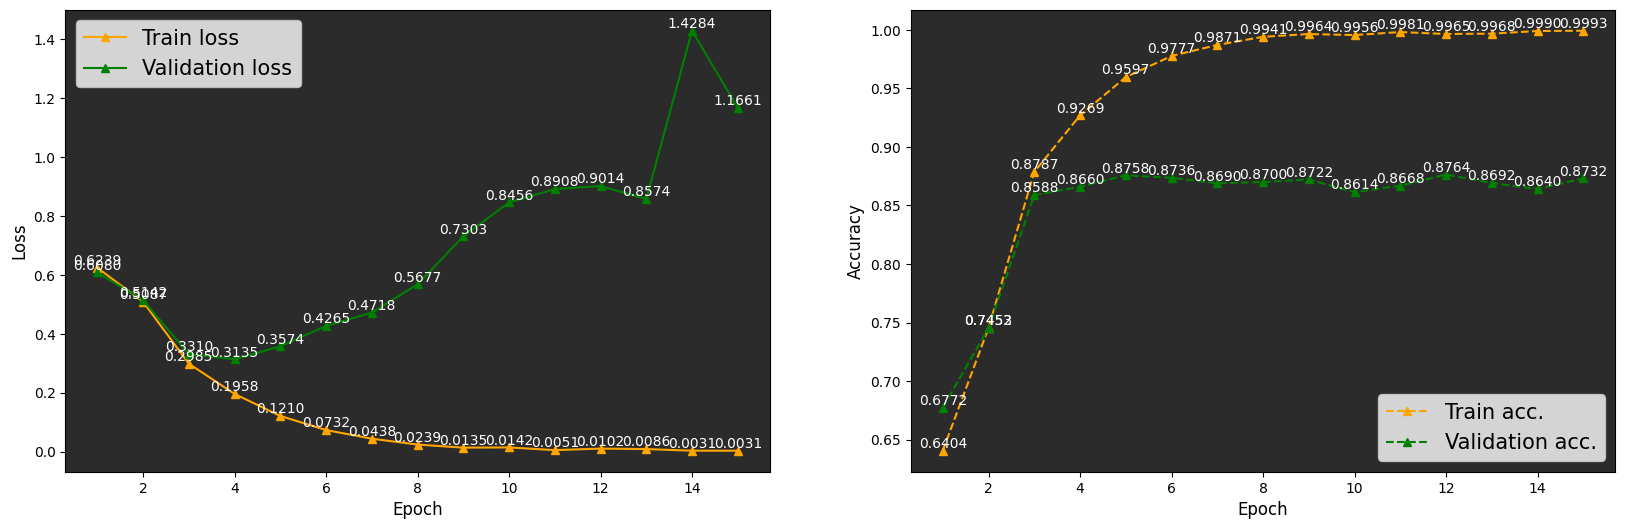

In [23]:
results = pd.DataFrame(results)  

hist_train_loss = results['Train Loss'].to_numpy()  
hist_val_loss   = results['Validation Loss'].to_numpy()  
hist_train_acc  = results['Train Accuracy'].to_numpy()  
hist_val_acc    = results['Validation Accuracy'].to_numpy()

x_arr = np.arange(len(hist_train_loss)) + 1  
fig = plt.figure(figsize=(20, 6))  

ax = fig.add_subplot(1, 2, 1)  
ax.plot(x_arr, hist_train_loss, '-^', label='Train loss', color='orange')   
ax.plot(x_arr, hist_val_loss, '-^', label='Validation loss', color='green')   
ax.legend(fontsize=15)  
ax.set_ylabel('Loss', size=12)  
ax.set_xlabel('Epoch', size=12)  
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist_train_loss):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

for i, value in enumerate(hist_val_loss):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

ax = fig.add_subplot(1, 2, 2)  
ax.plot(x_arr, hist_train_acc, '--^', label='Train acc.', color='orange')  
ax.plot(x_arr, hist_val_acc, '--^', label='Validation acc.', color='green')  
ax.legend(fontsize=15)  
ax.set_xlabel('Epoch', size=12)  
ax.set_ylabel('Accuracy', size=12)  
ax.set_facecolor('#2b2b2b')  

for i, value in enumerate(hist_train_acc):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

for i, value in enumerate(hist_val_acc):  
    ax.text(x_arr[i], value, f"{value:.4f}", ha='center', va='bottom', fontsize=10, color='white')  

plt.show()  

In [24]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}')

test_accuracy: 0.8584
